In [2]:
%load_ext autoreload
%autoreload 2

import sys

sys.path.append('/home/xilinx/jupyter_notebooks/qickdawg/src/')

import qickdawg as qd
from copy import copy
import matplotlib.pyplot as plt
import numpy as np

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [5]:
qd.start_client("172.16.26.5")

In [27]:
default_config = qd.NVConfiguration()

default_config.test = True
default_config.mw_readout_channel = 1
default_config.ddr4 = True
default_config.ddr4_channel = 0
default_config.n_ddr4_chunks = 200

default_config.adc_channel = 0 

default_config.mw_channel = 1
default_config.mw_nqz = 1
default_config.mw_gain = 5000

default_config.laser_gate_pmod = 0

default_config.relax_delay_treg = 100 # between each rep, wait for everything to catch up, mostly aom


In [28]:
config = copy(default_config)

config.soft_avgs = 1
config.readout_integration_treg = 1020
prog = qd.LaserOn(config)
_ = prog.acquire_decimated(progress=False)
data = prog.acquire_decimated(progress=False)
on_value  = np.mean(data)
print('Approximate on intensity {} ADC units'.format(on_value))

prog = qd.LaserOff(config)
_ = prog.acquire_decimated(progress=False)
data = prog.acquire_decimated(progress=False)
off_value  = np.mean(data)
print('Approximate off intensity {} ADC units'.format(off_value))


Approximate on intensity 1932.0107843137255 ADC units
Approximate off intensity -9.630392156862746 ADC units


In [98]:
for i in range(2):
    
    qd.soc.clear_ddr4()

    config = copy(default_config)
    config.mw_gain = 30000

    config.pre_init=True
    config.mw_pi2_treg = 100 # approximate pi/2 pulse in ns
    config.mw_fMHz = 2768

    config.readout_length_treg = 1020
    config.laser_initialize_treg = 5000 # in us

    config.mw_readout_delay_treg = 35  #
    config.laser_readout_offset_treg = 145 # <- Note this starts at 0 and we will change this based on the results

    config.ddr4_channel = i
    config.soft_avgs = 1

    prog = qd.ReadoutWindow(config)

    d = prog.acquire_decimated(raw_data=True)

    if i == 0:
        laser_ddr4 = qd.soc.get_ddr4(config.n_ddr4_chunks)[:, 0]
    elif i == 1:
        mw_ddr4 = qd.soc.get_ddr4(config.n_ddr4_chunks)
        mw_real = mw_ddr4[:, 0]
        mw_imag = mw_ddr4[:, 1]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

1 0


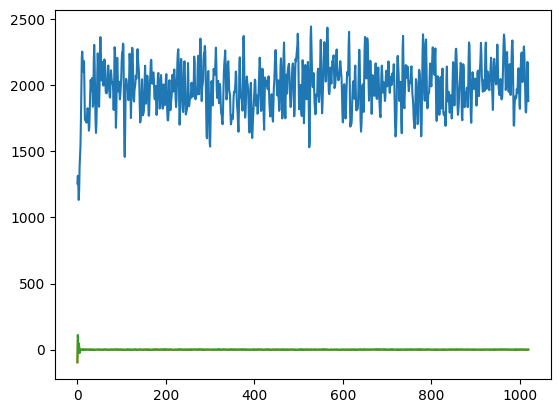

In [99]:
plt.plot(d[0][:, 0])
plt.plot(d[1][:, 0])
plt.plot(d[1][:, 1])


laser = d[0][:, 0]/ np.max(d[0][:, 0])
adc_laser_offset = np.where(np.array(laser) > 0.5)[0][0]

dx = d[1][:, 0]
dy = d[1][:, 1]
dm = np.sqrt(dx ** 2 + dy ** 2)
dm = dm/ np.max(dm)
mw_offset = np.where(dm >0.5)[0][-1] - adc_laser_offset
print(mw_offset, adc_laser_offset)




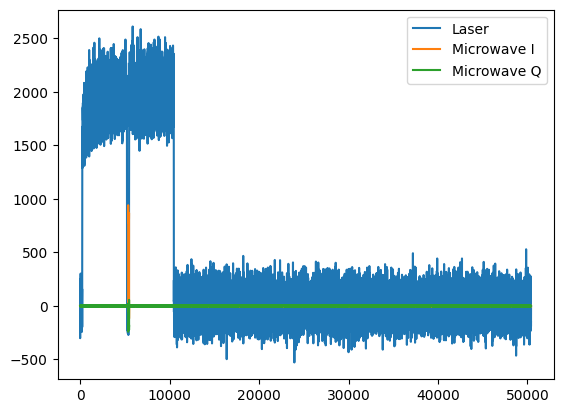

In [102]:
# phase = np.arctan(np.mean(mw_real[250:350]) / np.mean(mw_imag[250:350]))
# phase += np.pi/2
# 
x = mw_real * np.cos(phase) - mw_imag * np.sin(phase)
y = mw_real * np.sin(phase) + mw_imag * np.cos(phase)

plt.plot(laser_ddr4, label='Laser')
plt.plot(x, label='Microwave I')
plt.plot(y, label='Microwave Q')
# plt.xlim(0, 2000)
plt.legend()

In [60]:
print(prog.asm())


// Program

          regwi 1, $22, 604678826;              //freq = 2418715307
          bitwi 1, $22, $22 << 2;
          mathi 1, $22, $22 + 3;
          regwi 1, $23, 0;                      //phase = 0
          regwi 1, $25, 30000;                  //gain = 30000
          regwi 1, $26, 589924;                 //phrst| stdysel | mode | | outsel = 0b01001 | length = 100 
          synci 100;
          regwi 0, $16, 8192;                   //out = 0b0010000000000000
          seti 7, 0, $16, 0;                    //ch =0 out = $16 @t = 0
          seti 7, 0, $0, 10;                    //ch =0 out = 0 @t = 0
          synci 100;
          regwi 0, $13, 0;
          regwi 0, $14, 0;
LOOP_rep: synci 100;
          regwi 1, $27, 0;                      //t = 0
          set 1, 1, $22, $23, $0, $25, $26, $27;//ch = 1, pulse @t = $27
          synci 100;
          regwi 0, $16, 1;                      //out = 0b0000000000000001
          seti 7, 0, $16, 0;                    //ch =0 out